AI Hub에서 수리 견적 데이터를 가져와 수리 견적을 예측하는 모델 생성

Json파일에서 ['제작사/차종', '최초등록일']을 추출
['수리내역'] 부분에서 ['작업항목 및 부품명', '공임']을 추출하여 각 차종의 파손 부위에 따른 수리비용 테이블을 생성한다

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import glob, shutil
import os, json

import numpy as np
import pandas as pd

In [ ]:
%mkdir /content/data

In [ ]:
%cd /content/data

!unzip -qq "/content/drive/MyDrive/빅프로젝트/수리견적/견적예측/견적서.zip"

/content/data


### json 파싱 및 저장

'현대' 차량만 추출

In [ ]:
json_list = glob.glob('/content/data/'+'*')

len(json_list)

125006

In [ ]:
### 경로 안 모든 json 파일을 불러와 데이터프레임에 저장하는 함수
def make_repair_dataframe(path):

    json_list = glob.glob(path+'*')

    repair_data = pd.DataFrame(columns=[
                'name',
                'product_date',
                'part',
                'payment'])

    HD = '현대'
    coationg = '도장'

    for j in json_list:

        with open(j, 'r') as f:
            json_data = json.load(f)

        car_type = json_data['차량정보']['제작사/차종']
        if HD not in car_type:
            continue

        name = json_data['차량정보']['차량명칭']

        product_date = json_data['차량정보']['최초등록일'][:4]

        repair = json_data['수리내역']
        for r in repair:
            task = r['작업']
            if task != coationg:
                continue
            part = r['작업항목 및 부품명']

            if "손해사정후" in r:
                pay1 = 0 if r['손해사정후']['부품가격'] == "" else int(r['손해사정후']['부품가격'].replace(',', ''))
                pay2 = int(r['손해사정후']['공임'].replace(',', ''))
            else:
                pay1 = 0 if r['부품가격'] == "" else int(r['부품가격'].replace(',', ''))
                pay2 = int(r['공임'].replace(',', ''))
            payment = pay1 + pay2

            temp = pd.DataFrame({
                'name' : name,
                'product_date' : product_date,
                'part' : part,
                'payment' : payment
            }, index=[0])
            repair_data = pd.concat([repair_data, temp], ignore_index=True)

    # 기타 예외 처리

    return repair_data

In [ ]:
### 경로 안 모든 json 파일을 불러와 데이터프레임에 저장하는 함수
# def make_repair_dataframe(path):
    json_list = glob.glob(path+'*')

    repair_data = pd.DataFrame(columns=['car_type',
                'car_name',
                'product_date',
                'repair_part',
                'task',
                'repair_payment'])

    car_type_list = ['현대', '기아', '르노삼성', '쌍용', '한국GM']

    car_name_list = ['아반떼', '그랜드스타렉스', '카니발', '싼타페', '모닝', '그랜저', '쏘렌토', 'G80', '레이', '투싼', 'K7', '제네시스', '팰리세이드',
            '셀토스', '스포티지', 'K3', '그랜져', '쏘나타', 'EQ900', 'K5', '모하비', '벨로스터', '엑센트', 'K9', '그랜드카니발', '니로', 'QM3',
            '스팅어', 'SM7', '아이오닉', '트랙스', '맥스크루즈', '알페온', '쏘울', '코란도', '렉스턴', '베라크루즈', '아슬란', '코나', '티볼리',
            '크루즈', '프라이드', 'G70', '카렌스', 'SM5', '베뉴', 'SM3', 'i30', 'GV80', '아베오', '체어맨', '임팔라', '포르테', 'K8', '로체',
            'i40', 'SM 7', 'QM5', '그렌져', 'GV70', '스파크', '에쿠스', '말리부'
            ]

    for j in json_list:

        with open(j, 'r') as f:
            json_data = json.load(f)

        car_type = json_data['차량정보']['제작사/차종']
        if car_type not in car_type_list:
            continue

        car_name = json_data['차량정보']['차량명칭']
        for cn in car_name_list:
            if cn in car_name:
                car_name = cn

        product_date = json_data['차량정보']['최초등록일'][:4]

        repair = json_data['수리내역']

        for r in repair:
            repair_part = r['작업항목 및 부품명']
            repari_payment = r['공임']
            task = r['작업']

            temp = pd.DataFrame({
                'car_type' : car_type,
                'car_name' : car_name,
                'product_date' : product_date,
                'repair_part' : repair_part,
                'task' : task,
                'repair_payment' : repari_payment
            }, index=[0])
            repair_data = pd.concat([repair_data, temp], ignore_index=True)

    # 기타 예외 처리
    repair_data = repair_data.replace({'그랜져' : '그랜저', '그렌져' : '그랜저', 'SM 7' : 'SM7'})

    return repair_data

In [ ]:
path = '/content/data/'

HD_data = make_repair_dataframe(path)

In [ ]:
len(HD_data)

224171

In [ ]:
HD_data

,name,product_date,part,task,pay1,pay2,payment
0,아반떼AD(16),2017,리어 범퍼판금,도장,41400,62750,104150
1,아반떼AD(16),2017,리어 휀다(우)판금,도장,33900,54750,88650
2,아반떼AD(16),2017,공통시간작업,도장,0,50000,50000
3,아반떼AD(16),2017,가열건조비,도장,0,17278,17278
4,아반떼AD(16),2018,리어 범퍼교환,도장,43200,51750,94950
...,...,...,...,...,...,...,...
112871,코나,2019,가열건조비,도장,0,15869,15869
112872,코나,2019,컬러매칭,도장,18900,65330,84230
112873,올뉴투싼(15),2015,프런트범퍼 표면판금보수,도장,59400,94210,153610
112874,올뉴투싼(15),2015,가열건조비,도장,0,15869,15869


In [ ]:
HD_data.to_csv('/content/drive/MyDrive/빅프로젝트/HD_data.csv', index=False)

### 차량 및 부품 통일

각 수리 부분을 통일 ex) 후론트범퍼, 프런트범퍼 -> 앞범퍼

In [ ]:
''' 작업 내용

1. 힌지, 신지, 신찌, 사이드브라켓, 사이드마운팅브라켓 아웃사이드 핸들, 아웃사이드핸들은 가격이 매우 낮기 때문에 이상치를 유발할 가능성이 있다 -> 제거
2. '라지에터그릴'은 앞범퍼나 본넷에 포함시키는 것이 맞는가? (일단은 제거)
3. 앞유리 뒷유리 하체 없음

'''

In [ ]:
part_dict = {'앞범퍼' : ['후론트범퍼', '후론트 범퍼', '프런트범퍼', '프론트 범퍼'],
             '뒷범퍼' : ['리어범퍼', '뒤범퍼'],
             '앞도어' : ['후론트 도어', '프런트도어'],
             '뒷도어' : ['리어도어', '리어 도어', '슬라이딩 도어', '슬라이딩도어'],
             '트렁크' : ['트렁크리드', '트렁크리드판금', '트렁크리드교환'],
             }

car_name_list = ['아반떼', '스타렉스', '싼타페', '그랜저', 'G80', '투싼', '제네시스', '팰리세이드', '그랜져', '쏘나타',
        'EQ900', '벨로스터', '엑센트', '아이오닉', '맥스크루즈', '베라크루즈', '아슬란', '코나', 'G70', '베뉴', 'i30',
        'GV80', 'i40', '그렌져', 'GV70', '에쿠스',]

In [ ]:
# part_dict = {'앞범퍼' : ['후론트범퍼', '후론트 범퍼', '프런트범퍼', '프론트 범퍼'],
#              '앞펜더' : ['앞펜다', '프런트펜더', '후론트 휀다'],
#              '전조등' : ['헤드램프'],
#              '뒷범퍼' : ['리어범퍼', '뒤범퍼'],
#              '뒷펜더' : ['뒤휀더', '리어펜더', '리어 휀다'],
#              '후미등' : ['리어컴비네이션램프', '리어 컴비네이션램프'],
#              '앞도어' : ['후론트 도어', '프런트도어'],
#              '뒷도어' : ['리어도어', '리어 도어', '슬라이딩 도어', '슬라이딩도어'],
#              '사이드미러' : a['사이드 미러', '사이드미러'],
#              '스텝' : ['사이드스텝', '사이드 스텝'],
#              '전방바퀴' : ['후론트휠', '후론트 휠', '프런트휠'],
#              '후방바퀴' : ['리어 휠', '리어휠'],
#              '본넷' : ['본네트', '본네트교환', '본네트판금', '후드'],
#              '루프' : ['루프패널', '루프 패널판금'],
#              '트렁크' : ['트렁크리드', '트렁크리드판금', '트렁크리드교환'],
#              'A필러' : ['후론트 필러', '프런트필러'],
#              'C필러' : ['리어필러', '리어 필러'],
#              }

In [ ]:
# 함수로 작성
def clean_repair_dataframe(data):
    repair_data = data.copy()

    # na제거
    repair_data = repair_data.dropna()

    # 가격이 낮은 값들 제거, 트라제, 베르나 제거
    repair_data = repair_data[~repair_data['part'].str.contains('신지|신찌|힌지|사이드브라켓|사이드마운팅브라켓|아웃사이드 핸들|아웃사이드핸들')]
    repair_data = repair_data[~repair_data['name'].str.contains('트라제XG|베르나|스타리아|에쿠스')]

    for cn in car_name_list:
        repair_data.loc[repair_data['name'].str.contains(cn), 'name'] = cn
    repair_data = repair_data.replace({'그랜져' : '그랜저', '그렌져' : '그랜저',})

    # 프론트범퍼, 후론트 범퍼과 같이 불규칙한 이름을 앞범퍼와 같이 통일
    for part, change_list in part_dict.items():
      for e in change_list:
        repair_data.loc[repair_data['part'].str.contains(e), 'part'] = part


    # 나머지 기타 부품들 제거
    part_list = list(part_dict.keys())
    repair_data = repair_data[repair_data['part'].isin(part_list)]

    # repair_data['payment'] = repair_data['payment'].str.replace(',', '').astype('int64')

    return repair_data

In [ ]:
HD_data = pd.read_csv('/content/drive/MyDrive/빅프로젝트/HD_data.csv')

In [ ]:
HD_data = clean_repair_dataframe(HD_data)

## 단변량 분석

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'NanumGothic'

In [ ]:
HD_data['product_date'].value_counts()

2018    12422
2016    11653
2017    10245
2020     9319
2019     8771
2015     5755
2021     2451
2014     1558
2013      970
2012      801
2000        4
2010        3
2011        1
Name: product_date, dtype: int64

In [ ]:
HD_data = HD_data.loc[HD_data['product_date'] > 2011]

In [ ]:
HD_data.describe()

,product_date,payment
count,62244.000000,62244.000000
mean,2017.516291,111964.081630
std,1.930356,33951.328589
min,2012.000000,40000.000000
25%,2016.000000,82410.000000
50%,2018.000000,112120.000000
75%,2019.000000,136460.000000
max,2021.000000,199900.000000


In [ ]:
HD_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63945 entries, 0 to 224169
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          63945 non-null  object
 1   product_date  63945 non-null  int64 
 2   part          63945 non-null  object
 3   payment       63945 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 2.4+ MB


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


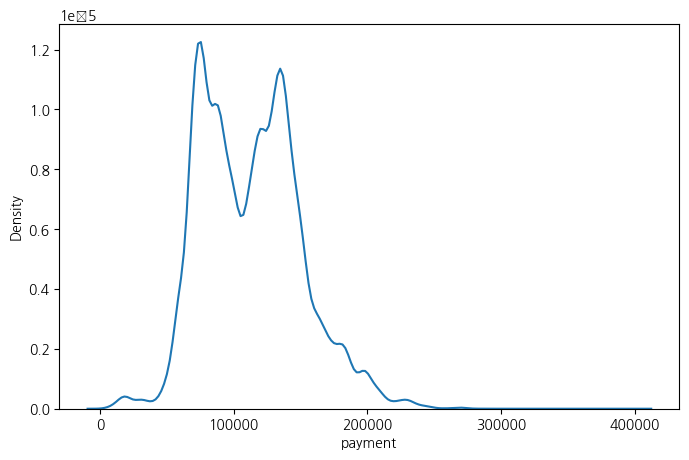

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(HD_data['payment'])
plt.show()

In [ ]:
HD_data = HD_data.loc[(HD_data['payment'] >= 40000) & (HD_data['payment'] <= 200000)]

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


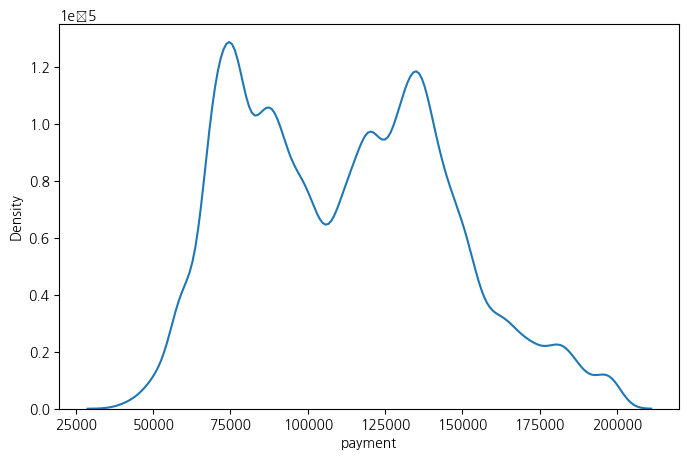

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(HD_data['payment'])
plt.show()

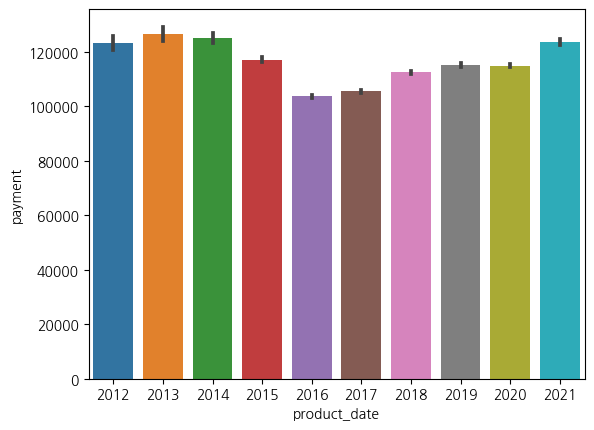

In [ ]:
sns.barplot(x="product_date", y="payment", data=HD_data)
plt.show()

In [ ]:
temp = HD_data.loc[(HD_data['part'] == '뒷범퍼')]

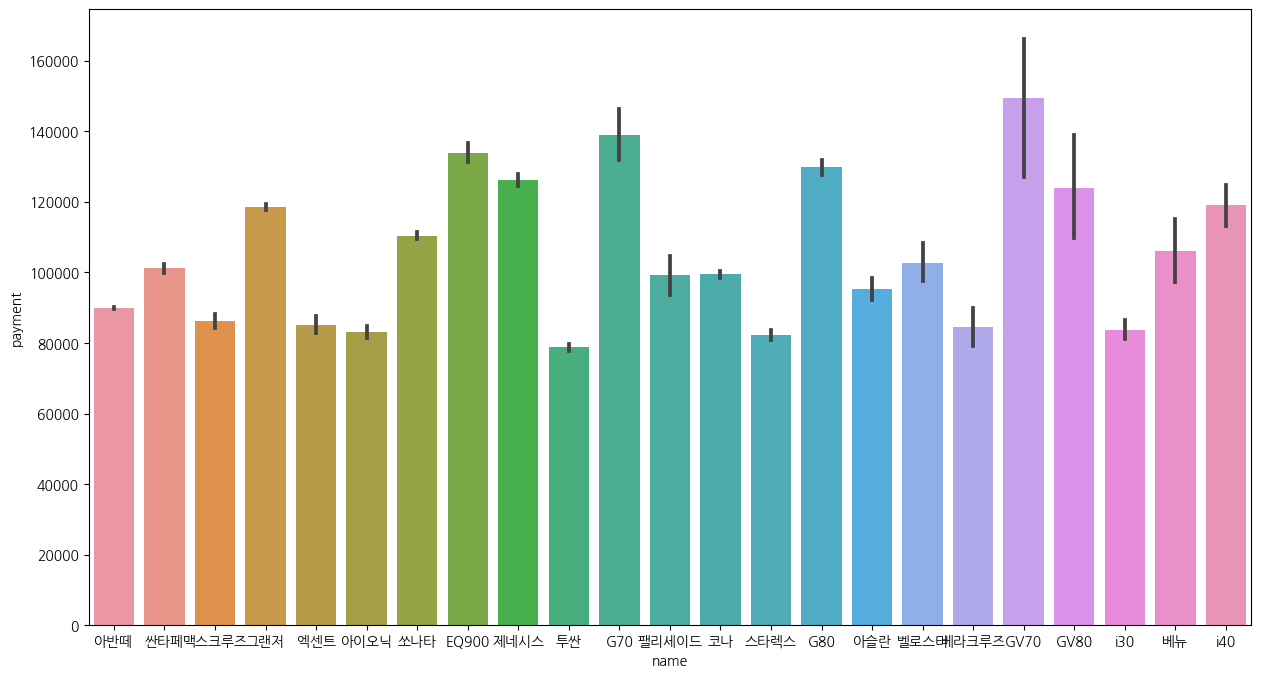

In [ ]:
plt.figure(figsize=(15,8))
sns.barplot(x="name", y="payment", data=temp)
plt.show()

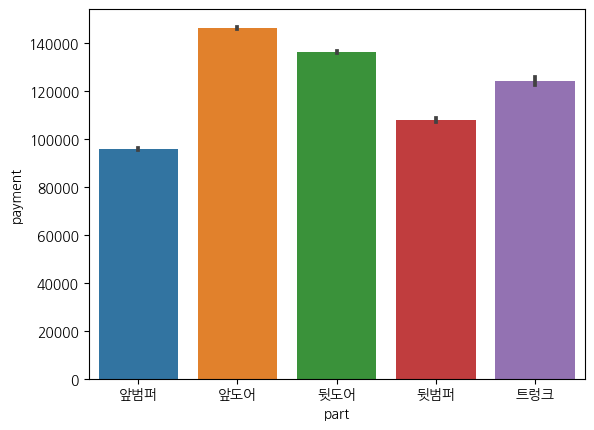

In [ ]:
sns.barplot(x="part", y="payment", data=HD_data)
plt.show()

In [ ]:
grandure = HD_data.loc[HD_data['name'] == '그랜저']

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


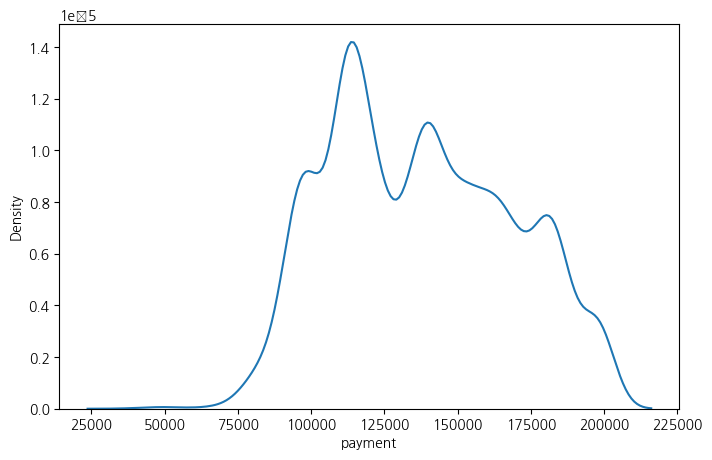

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(grandure['payment'])
plt.show()

In [ ]:
grandure['part'].value_counts()

앞범퍼    2886
뒷도어    1406
앞도어    1125
뒷범퍼     430
트렁크     383
Name: part, dtype: int64

In [ ]:
front = grandure.loc[grandure['part'] == '앞범퍼']

In [ ]:
sns.kdeplot(front['payment'])
plt.show()

In [ ]:
plt.boxplot(front['payment'])
plt.show()

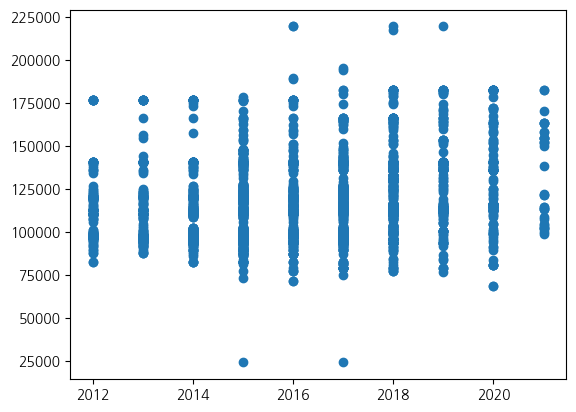

In [ ]:
plt.scatter(front['product_date'], front['payment'])
plt.show()

In [ ]:
import scipy.stats as spst
spst.pearsonr(front['product_date'], front['payment'])

PearsonRResult(statistic=0.23561782071863482, pvalue=1.0664847005113747e-37)

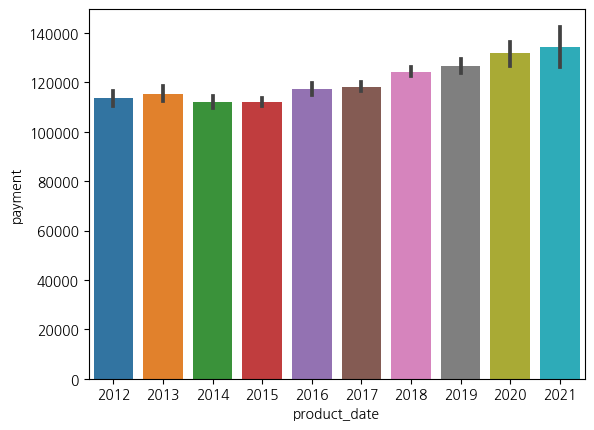

In [ ]:
sns.barplot(x="product_date", y="payment", data=front)
plt.show()

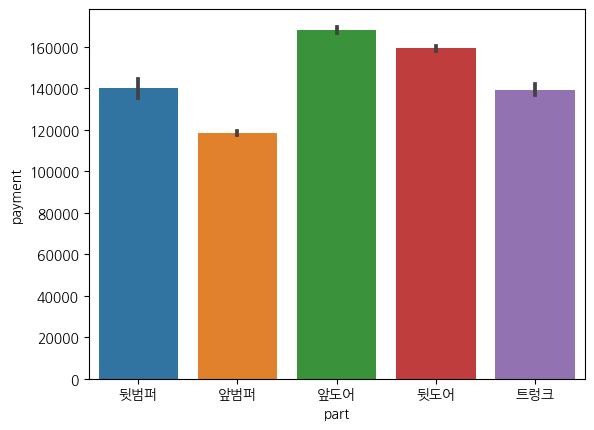

In [ ]:
sns.barplot(x="part", y="payment", data=grandure)
plt.show()

In [ ]:
HD_data

,name,product_date,part,payment
0,아반떼,2020,앞범퍼,69700
3,아반떼,2020,앞도어,109950
4,아반떼,2020,뒷도어,146750
11,아반떼,2018,앞범퍼,76350
15,그랜저,2019,뒷범퍼,182630
...,...,...,...,...
224161,그랜저,2014,앞범퍼,112650
224165,코나,2019,앞도어,135300
224166,코나,2019,뒷도어,129350
224168,코나,2020,앞도어,135300


In [ ]:
HD_data.to_csv('/content/drive/MyDrive/빅프로젝트/repair_payment.csv')